# Using SAS DLPy to Create a Deep Learning Model to Classify gender from faces 
The following example uses SAS DLPy to create a CNN(convolutional) image classification model. The model task is to analyze faces captured by a computer webcam and determine gender


## Table of Contents

   * Setup Libraries and Launch CAS
   * Load and Explore the Training Data
   * Prepare the Data for Modeling
   * Specify the Model Architecture, Configure Model Parameters, Import Pre-Trained Weights
   * Fit the Image Detection and Classification Model
   * Score the Test Data to Predict Image Classes
   * Visualize Model Leanring
   * Save Model as ASTORE for Deployment   
   

## SWAT Setup 

In order for python to communicate with Viya and issue CAS actions the SWAT module is needed. https://github.com/sassoftware/python-swat  (Scripting Wrapper for Analytics Transfer)  

In [21]:
import sys
sys.path.append("/opt/sasinside/anaconda3/lib/python3.6/site-packages")
import  swat  # Sets up session with Viya and controls CAS actions
from swat import *
swat.__version__

'1.5.1'

## Setup Standard Python Libraries

In [22]:
import matplotlib.pyplot as plt  # graphing 
%matplotlib inline
import numpy as np    # multidementions array manipulator 
import pandas as pd   # data analysis
import random

## Import Deep Learning Module

DLPy is a high-level package for the Python APIs created for the
SAS Viya 3.3 (and newer) Deep Learning and Image action sets. DLPy
provides a convenient way to perform deep learning image processing.
https://gitlab.sas.com/bsloane/dlpy

In [23]:
import dlpy
from dlpy import Model, Sequential
from dlpy.model import *
#from dlpy.layers import *
from dlpy.applications import *
from dlpy.utils import *
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split
from dlpy.blocks import *
dlpy.__version__ 


'1.0.1'

After importing the required libraries and utilities, connect to SAS CAS. You will need to know the name of your CAS server and port ID, as well as your userID and password.

In [24]:
s = swat.CAS('iotdepot',"5570", "sasdemo","sasdemo") 
serverstatus = s.serverStatus()
#serverstatus

NOTE: Grid node action status report: 1 nodes, 8 total actions executed.


## Load Deep Learning Action Sets

While CAS comes with a few pre-loaded action sets, you will likely want to load action sets with other capabilities such as percentiles, Data step, SQL, or even machine learning. Most action sets will require a license to run them, so you’ll have to take care of those issues before you can load them.

In [25]:
s.loadactionset('image')
s.loadactionset('deepLearn')

NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.00404s, user: 0.000122s, sys: 0.00389s, mem: 0.23mb

#### There are 2 inputs needed to train a model.  
    1. Images files 
    2. Pre-trained weights file
#### We will also need a caslib location on the CAS server to store working files and  results.  This path is system dependant so ask your system admin for the correct location.  

In [26]:
modelPath='/data/'
s.table.addcaslib(activeonadd=True,datasource={'srctype':'path'},name='Happy',path=modelPath,subdirectories=True)
s.setsessopt(caslib='Happy')  #  Set default active caslib


NOTE: 'Happy' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'Happy'.
NOTE: 'Happy' is now the active caslib.


+ Elapsed: 0.000384s, user: 0.000169s, sys: 0.0002s, mem: 0.243mb

In [27]:
s.table.caslibInfo() 

,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
0,CASUSER(sasdemo),PATH,Personal File System Caslib,/home/sasdemo/casuser/,,1.0,0.0,0.0,1.0,0.0,1.0
1,Public,PATH,"Shared and writeable caslib, accessible to all...",/opt/sas/viya/config/data/cas/default/public/,,0.0,0.0,0.0,0.0,0.0,0.0
2,Happy,PATH,,/data/,,1.0,1.0,1.0,0.0,0.0,0.0


In [17]:
s.tableinfo()

NOTE: No tables are available in caslib Happy of Cloud Analytic Services.


+ Elapsed: 0.000552s, sys: 0.000523s, mem: 0.293mb

## Load and Explore the Training Data

Now use load_files from DLPy ImageTable to create a CAS table named my_images. Labels are inherited from subdirectory names when you use load_files.  For example, the images directory contains 2 subdirectories (Happy and Angry).  All images in the Happy subdirectory will be labled Happy regardless of file name.  

In [28]:
#s.setsessopt(caslib='Happy')  #  Set default active caslib
modelPath='/data/'
my_images = ImageTable.load_files(s, path=modelPath+'genderimages',casout=dict(name='my_images',caslib='Happy'))

In [29]:
s.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,MY_IMAGES,23708,4,0,utf-8,2019-06-28T15:19:55-04:00,2019-06-28T15:19:55-04:00,2019-06-28T15:19:55-04:00,UTF8,1.877369e+09,...,0,0,0,,,0,sasdemo,,,NaN


#### Use show() to display a table of 8 randomly selected images, in two rows of 4 columns.

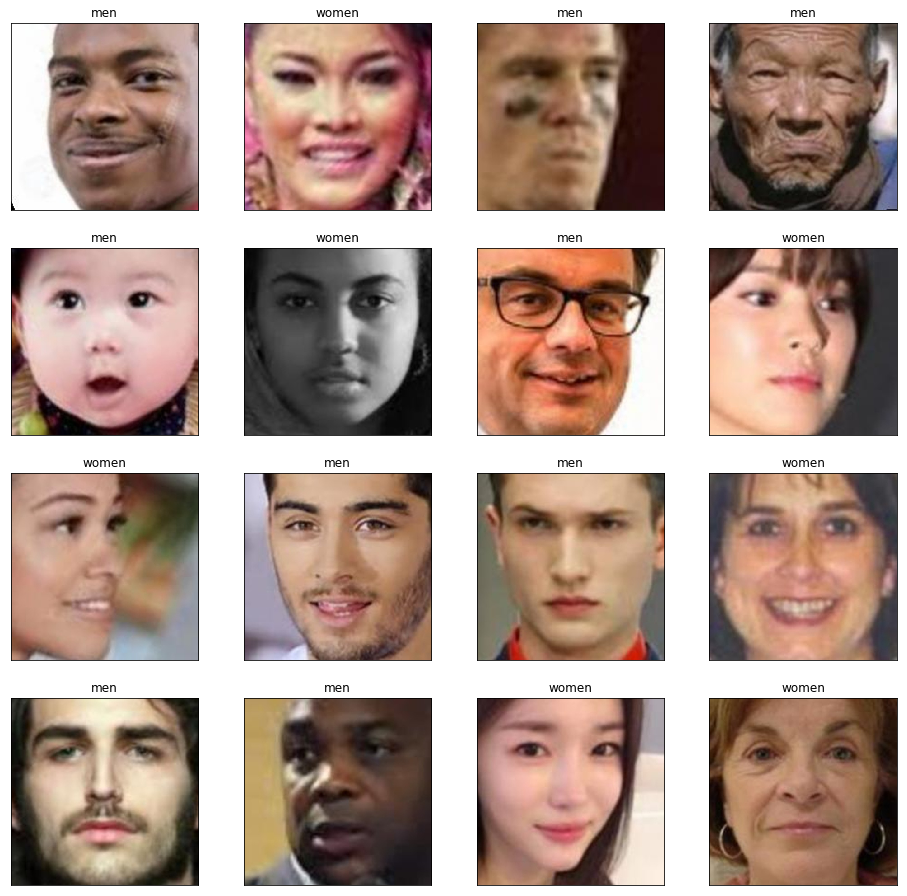

In [31]:
my_images.show(nimages=16, ncol=4, randomize=True)

In [32]:
my_images.head()

,_image_,_label_,_filename_0,_id_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,men,men8020.jpg,1
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,men,men8106.jpg,2
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,men,men19989.jpg,3
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,men,men23545.jpg,4
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,men,men2195.jpg,5


##  Frequency 
Use the label_freq() function to verify the amount of entries from each class in the table. 

In [33]:
my_images.label_freq

,Level,Frequency
men,1,12391
women,2,11317


## Image Summary 
Use the image_summary function to generate a summary table of the attributes of the images in the model data.  In this case the images are 48 by 48 pixels.  These images need to be at least 128 pixels to run through our CNN.  In the next steps we will augment the images to the desired dementions. 

In [34]:
my_images.image_summary

jpg                 23708
minWidth              416
maxWidth              416
minHeight             416
maxHeight             416
meanWidth             416
meanHeight            416
mean1stChannel      99.61
min1stChannel           0
max1stChannel         255
mean2ndChannel    116.376
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    151.986
min3rdChannel           0
max3rdChannel         255
dtype: object

## Shuffle

It is always a good staticical practice to shuffle the dataset before training.  

In [35]:
# Shuffle Images
my_images.shuffle(casout=dict(name='my_images', replace=True));

## Resize 

In our case, we need to increase the size of the images to 224. 

In [36]:
my_images.resize(width=224, height=224)

## Split Images into Training and Testing Datasets

Now use the two_way_split() function to divide the model data into train and test partitions. Use random seed 215, and partition the data so that 80% of observations are allocated to the train partition tr_img and 20% of observations are allocated to the test partition te_img.

In [37]:
tr_img, te_img = two_way_split(my_images, test_rate=20, stratify_by='_label_', seed = 215)

In [38]:
my_images.summarizeimages()

NOTE: Table MY_IMAGES contains compressed images.
NOTE: 23708 out of 23708 images were scanned and results were saved to the summary table.


,Column,jpg,minWidth,maxWidth,minHeight,maxHeight,meanWidth,meanHeight,mean1stChannel,min1stChannel,max1stChannel,mean2ndChannel,min2ndChannel,max2ndChannel,mean3rdChannel,min3rdChannel,max3rdChannel
0,_image_,23708.0,224.0,224.0,224.0,224.0,224.0,224.0,99.519214,0.0,255.0,116.284351,0.0,255.0,151.884684,0.0,255.0


In [39]:
tr_img.label_freq

,Level,Frequency
men,1,9913
women,2,9054


In [40]:
te_img.label_freq

,Level,Frequency
men,1,2478
women,2,2263


## Specify VGG16 Model Architecture, Configure Model Parameters, Import Pre-Trained Weights
This example uses a pre-defined VGG16 model architecture with pre-trained weights to detect and classify the face images. The model weights are saved in a Caffe format .h5 file. The following code uses DLPy to create a VGG16 model named model_vgg16. The model architecture will have 2 classes in the final prediction layer.

The code configures the model to process color images sized 244 x 244 pixels. The BGR (Blue, Green, Red) color offsets are stored in tr_img.channel_means. The image_summary for this augmented data shows the channel_means values are 126.251 (B), 126.251 (G), and 126.251 (R).  My image dataset were greyscale. Therefore, the channel_means are 255/2.  

The model is configured to use pre-trained weights, using the specified weight file VGG_ILSVRC_16_layers.caffemodel.h5, which is located in the pre-defined directory path dir_path.

Since the model_vgg16 value for include_top=False, the imported model weights are loaded for all model layers except the final prediction layer.

Note: You can obtain the VGG16 model files used in this example from the SAS technical support web at by using the following URL: https://support.sas.com/documentation/prod-p/vdmml/zip/vgg16.zip.

In [13]:
# Use Popular VGG16 Model
# Loading Pre-Trained Weights 
model_vgg16 = VGG16(
    s,
    model_table='VGG16_notop',
    n_classes=2,
    n_channels=3,
    width=224,
    height=224,
    scale=1,
    random_flip='hv',
    offsets=tr_img.channel_means,
    pre_trained_weights=True,
    pre_trained_weights_file=modelPath+'VGG_ILSVRC_16_layers.caffemodel.h5',
    include_top=False)

NOTE: Model weights attached successfully!
NOTE: Model table is attached successfully!
NOTE: Model is named to "vgg16_notop" according to the model name in the table.


In [14]:
# Set Optimization and Algorithm Paramters
model_vgg16.fit(data=tr_img,
                valid_table=te_img, 
                inputs='_image_', 
                target='_label_',
                mini_batch_size=4,
                max_epochs=5,
                lr=0.001,
                #gpu=dict(devices=[2]),
                gpu=None,
                #n_threads=4,
                log_level=2);

NOTE: Training based on existing weights.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 134268738.
NOTE:  The approximate memory cost is 12740.00 MB.
NOTE:  Loading weights cost       1.36 (s).
NOTE:  Initializing each layer cost      22.32 (s).
NOTE:  The total number of threads on each worker is 10.
NOTE:  The total mini-batch size per thread on each worker is 4.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 40.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Angry
NOTE:  Level      1: Happy
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch           Learning Rate     Loss    Fit Error   Validation Loss   Validation Error    Time (s)
NOTE:          0           0.001       0.8788     0.4688          0.7008            0.425       18187.46
NOTE:          1           0

## Checking Results

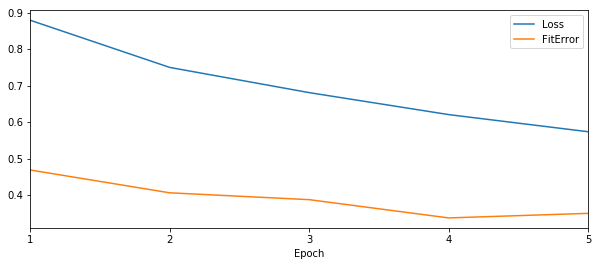

In [48]:
model_vgg16.plot_training_history(fig_size=(10,4))

## Model Summary 

Use the print_summary function to view the model structure.  Here you can see each layer along with their types (Conv,pool,relu,FC).  

In [24]:
model_vgg16.print_summary() # VGG16 b/c 16 Learnable Layers

,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,data,input,None,None,None,"(224, 224, 3)","(0, 0)"
1,conv1_1,convo,"(3, 3)",1,Rectifier,"(224, 224, 64)","(1728, 64)"
2,conv1_2,convo,"(3, 3)",1,Rectifier,"(224, 224, 64)","(36864, 64)"
3,pool1,pool,"(2, 2)",2,Max,"(112, 112, 64)","(0, 0)"
4,conv2_1,convo,"(3, 3)",1,Rectifier,"(112, 112, 128)","(73728, 128)"
5,conv2_2,convo,"(3, 3)",1,Rectifier,"(112, 112, 128)","(147456, 128)"
6,pool2,pool,"(2, 2)",2,Max,"(56, 56, 128)","(0, 0)"
7,conv3_1,convo,"(3, 3)",1,Rectifier,"(56, 56, 256)","(294912, 256)"
8,conv3_2,convo,"(3, 3)",1,Rectifier,"(56, 56, 256)","(589824, 256)"
9,conv3_3,convo,"(3, 3)",1,Rectifier,"(56, 56, 256)","(589824, 256)"


## Specify ResNet50 Model Architecture, Configure Model Parameters, Import Pre-Trained Weights

This example uses a pre-defined ResNet50 model architecture with pre-trained weights to detect and classify the face images. The model weights are saved in a Caffe format .h5 file. The following code uses DLPy to create a ResNet50 model named model_R50. The model architecture will have 2 classes in the final prediction layer.

The code configures the model to process color images sized 244 x 244 pixels. The BGR (Blue, Green, Red) color offsets are stored in tr_img.channel_means. The image_summary for this augmented data shows the channel_means values are 126.251 (B), 126.251 (G), and 126.251 (R).  My image dataset were greyscale. Therefore, the channel_means are 255/2.  

The model is configured to use pre-trained weights, using the specified weight file ResNet-50-model.caffemodel.h5, which is located in the pre-defined directory path dir_path.

Since the model value for include_top=False, the imported model weights are loaded for all model layers except the final prediction layer.

Note: You can obtain the model weight files used in this example from the SAS technical support web at by using the following URL: https://support.sas.com/documentation/prod-p/vdmml/zip/

In [41]:
model_R50 = ResNet50_Caffe(s, n_channels=3, random_flip='HV', 
                       pre_trained_weights_file=modelPath+'ResNet-50-model.caffemodel.h5',
                       pre_trained_weights=True,
                       offsets=tr_img.channel_means,
                       include_top=False, n_classes=2, random_crop='none')
model_R50.print_summary()

NOTE: Model weights attached successfully!
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50_caffe" according to the model name in the table.


,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,data,input,None,None,None,"(224, 224, 3)","(0, 0)"
1,conv1,convo,"(7, 7)",2,Identity,"(112, 112, 64)","(9408, 64)"
2,bn_conv1,batchnorm,None,None,Rectifier,"(112, 112, 64)","(0, 128)"
3,pool1,pool,"(3, 3)",2,Max,"(56, 56, 64)","(0, 0)"
4,res2a_branch2a,convo,"(1, 1)",1,Identity,"(56, 56, 64)","(4096, 0)"
5,bn2a_branch2a,batchnorm,None,None,Rectifier,"(56, 56, 64)","(0, 128)"
6,res2a_branch2b,convo,"(3, 3)",1,Identity,"(56, 56, 64)","(36864, 0)"
7,bn2a_branch2b,batchnorm,None,None,Rectifier,"(56, 56, 64)","(0, 128)"
8,res2a_branch2c,convo,"(1, 1)",1,Identity,"(56, 56, 256)","(16384, 0)"
9,bn2a_branch2c,batchnorm,None,None,Identity,"(56, 56, 256)","(0, 512)"


In [49]:
model_R50.plot_network()

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [44]:
my_images.head()

,_filename_0,_image_,_id_,_label_
0,men6644.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,64,men
1,men17670.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,4841,men
2,men15574.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,4243,men
3,men22410.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,10771,men
4,men16135.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1323,men


#### DataSpec Variables


In [30]:
inputVars = []
inputVars.insert(0,'_image_')
targets = []
targets.insert(0,'_label_')


## Train Model 

#### Warning, this task will take many hours to complete.  

The fit function trains the model which was created above using back propagation and gradient decent algorithms.  Each epoch represents one forward pass and one backward pass of all the training examples. The model uses 4 observations per thread in a mini-batch. Training uses a learning rate of 0.001, and with a maximum of 15 epochs. Setting log_level=2 configures the output to produce an iteration history. 

In [45]:
solver=dlpy.model.MomentumSolver( momentum = 0.9,
                      learning_rate = 0.001 ,  
                      clip_grad_min = -100,
                      clip_grad_max = 100,
                      learning_rate_policy = 'MULTISTEP',
                      gamma = 0.1,             # multiplied by LR after step is reached 
                      steps = [15, 40]  # epoch number 
                     )
solver2=dlpy.model.AdamSolver(    beta1 = 0.9,
                      beta2=.999,
                      learning_rate = 0.001 ,  
                      clip_grad_min = -1000,
                      clip_grad_max = 1000
                   )
optimization=dlpy.model.Optimizer(algorithm=solver,
                       reg_l2 = 0.001,  # helps with over fitting
                       max_epochs = 60,
                       log_level = 2
                      )
#data_specs = [DataSpec(type_='IMAGE', layer='input', data=inputVars),
#              DataSpec(type_='OBJECTDETECTION', layer='output', data=targets)]
gpu = Gpu(devices=[0])
#gpu = None

# Fit model with training data
model_R50.fit(data=tr_img,
          valid_table=te_img, 
          inputs='_image_', 
          target='_label_',
          #record_seed=-13,
          mini_batch_size=1,
          n_threads= None,  #  if not set all cores used.     
          optimizer=optimization ,
          gpu=gpu )

NOTE: Training based on existing weights.
NOTE: Using 4ca0ee83fca8: 1 out of 1 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 23512194.
NOTE:  The approximate memory cost is 571.00 MB.
NOTE:  Loading weights cost       0.07 (s).
NOTE:  Initializing each layer cost       3.58 (s).
NOTE:  The total number of threads on each worker is 20.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 20.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: men  
NOTE:  Level      1: women
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  0         0.001          0.3168     0.1411           0.3168           0.1405    92.40
N

,Descr,Value
0,Model Name,resnet50_caffe
1,Model Type,Convolutional Neural Network
2,Number of Layers,126
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,53
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,53
9,Number of Residual Layers,16


## Checking Results

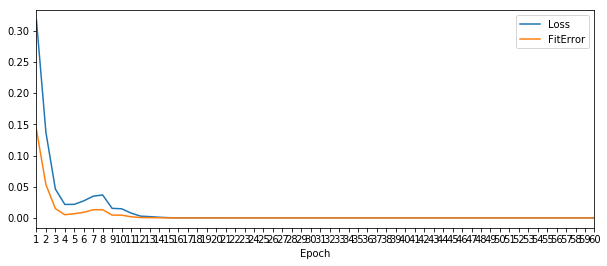

In [46]:
model_R50.plot_training_history(fig_size=(10,4))


## Score the Test Data to Predict Image Classes

Use evaluate() to use model to score the model data in te_img.

The output includes tables that summarize model scoring parameters and the names of model output tables in CAS.

In [47]:
evaluate = model_R50.evaluate(data=te_img, gpu = Gpu(devices=[0]) )
evaluate

NOTE: Using 4ca0ee83fca8: 1 out of 1 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          4741
 1  Number of Observations Used          4741
 2  Misclassification Error (%)      7.044927
 3                   Loss Error       0.38294

[OutputCasTables]

   casLib              Name  Rows  Columns  \
 0  Happy  Valid_Res_12ANmQ  4741        9   
 
                                        casTable  
 0  CASTable('Valid_Res_12ANmQ', caslib='Happy')  

+ Elapsed: 8.31s, user: 17s, sys: 1.91s, mem: 488mb

In [48]:
s.columninfo('Valid_Res_12ANmQ')

,Column,Label,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,_image_,,1,varbinary,26229,26229,,0,0
1,_label_,,2,varchar,5,5,,0,0
2,_filename_0,,3,varchar,14,14,,0,0
3,_id_,,4,int64,8,12,,0,0
4,P__label_men,Predicted: _label_=men,5,double,8,12,BEST,12,0
5,P__label_women,Predicted: _label_=women,6,double,8,12,BEST,12,0
6,I__label_,,7,char,5,5,$,5,0
7,_DL_PredP_,Highest predicted probability,8,double,8,12,BEST,12,0
8,_DL_PredLevel_,Predicted level with highest probability,9,double,8,12,BEST,12,0


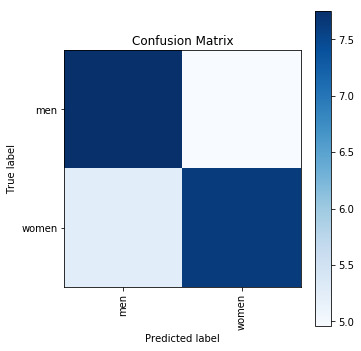

In [50]:
target_names = ["men","women"]
cmr = s.crosstab(table='Valid_Res_12ANmQ', row='_label_', col='I__label_')
confM = cmr.Crosstab[['Col1','Col2'
                     ]].head(2).values

#confMNorm = confM.astype('float') / confM.sum(axis=1)[:, np.newaxis]
confMLogNorm = np.log(confM.astype('float')) 
#print confMLogNorm
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names,rotation=90)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize=(5,5))
plot_confusion_matrix(confMLogNorm)

## View Scored Image Examples

Let's look at a few example images from the scored data, and see how the model evaluated the classification. Images are selected by random and the class value for the classification img_type attribute. The img_type attribute values are C, M, or A.

Scored images that are img_type='C' are correctly classified images. Scored images that are img_type='M' are misclassified images. The img_type='A' class returns all scored images, whether correctly classified or misclassifed.

The following code uses plot_evaluate_res() to view two correctly classified images selected at random from scored model data:

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib Happy.


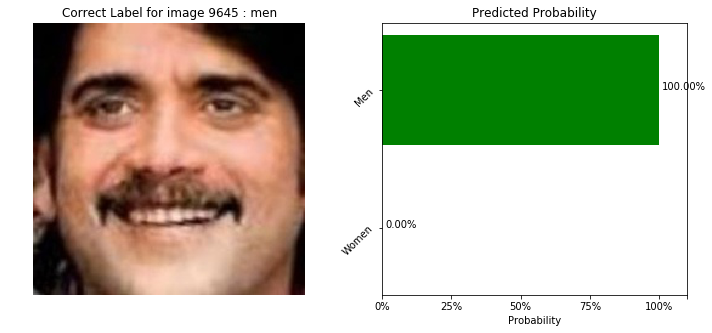

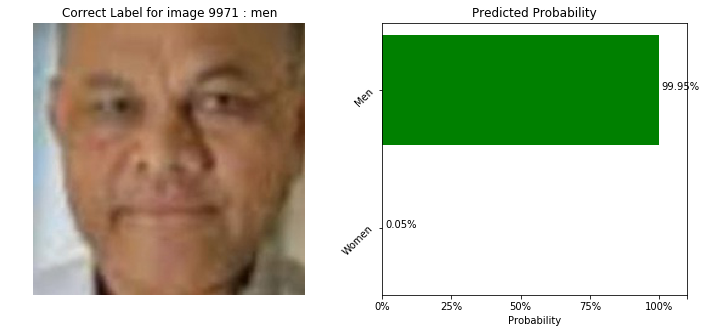

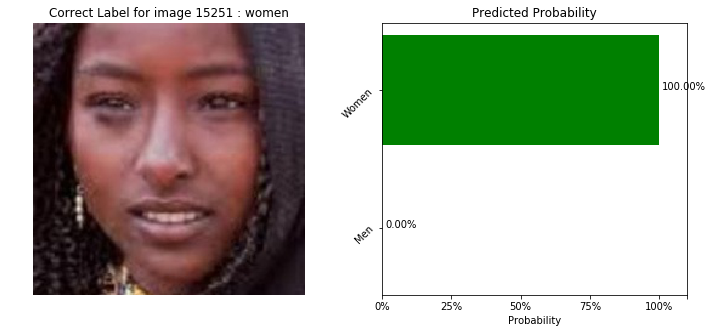

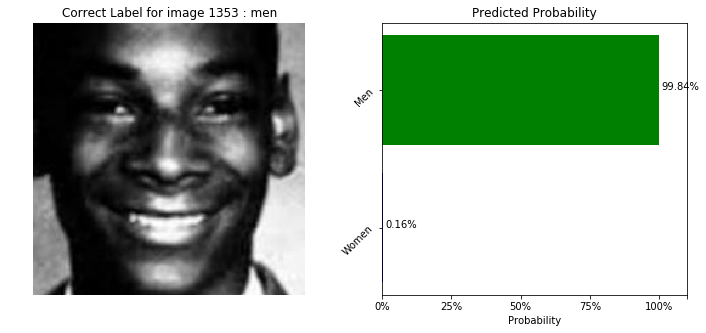

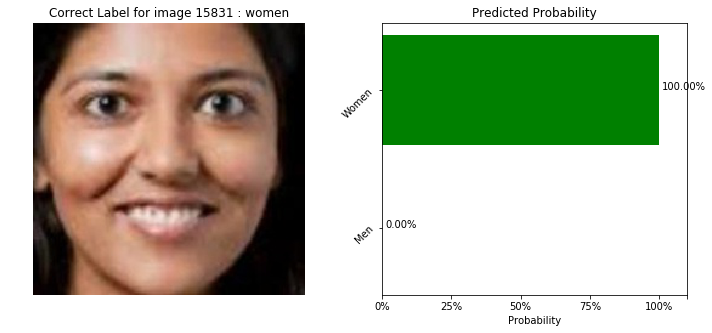

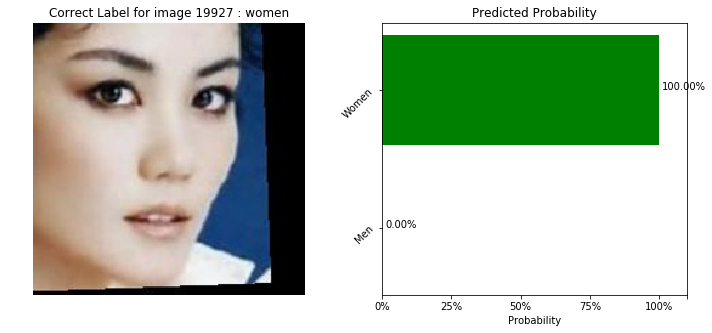

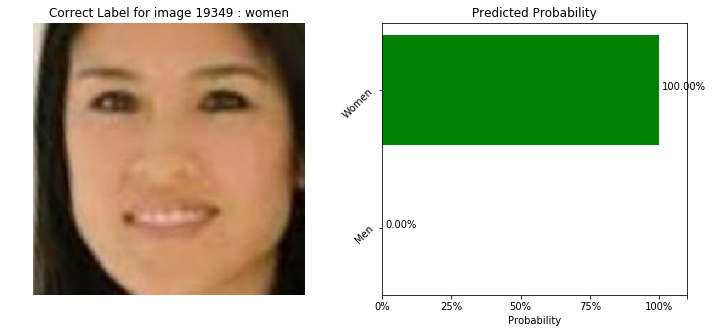

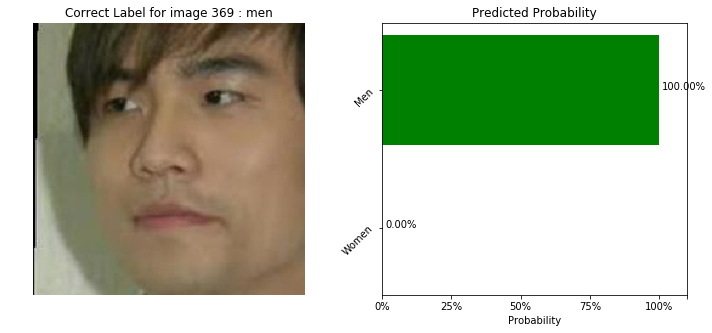

In [56]:
model_R50.plot_evaluate_res(img_type='C',randomize=True,n_images=8)

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib Happy.


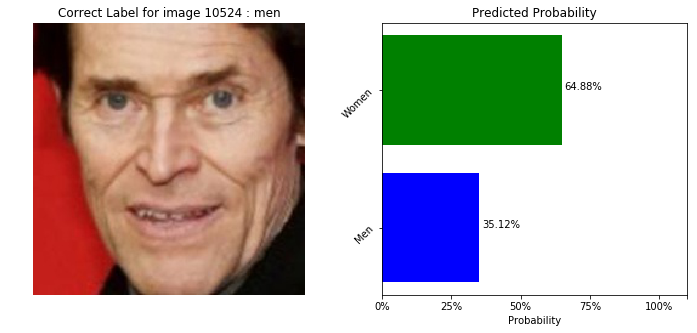

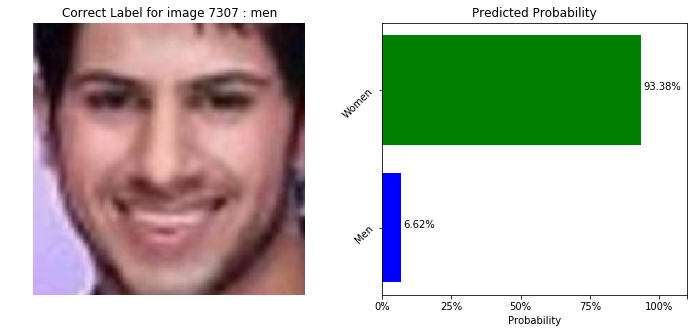

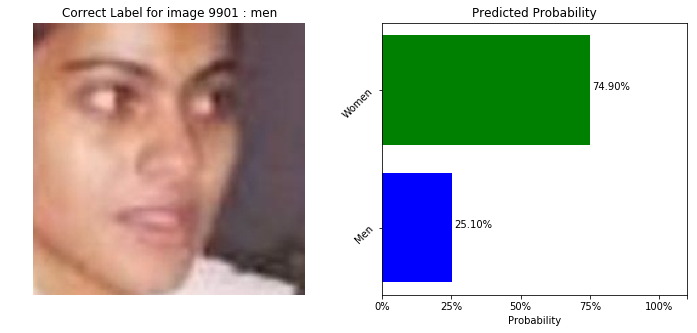

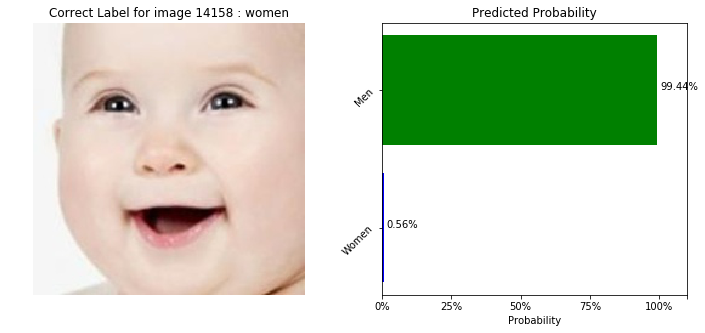

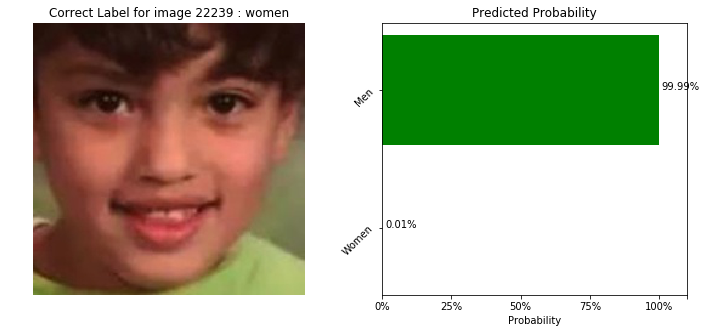

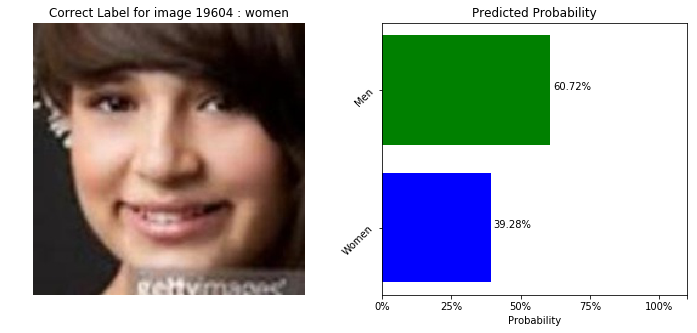

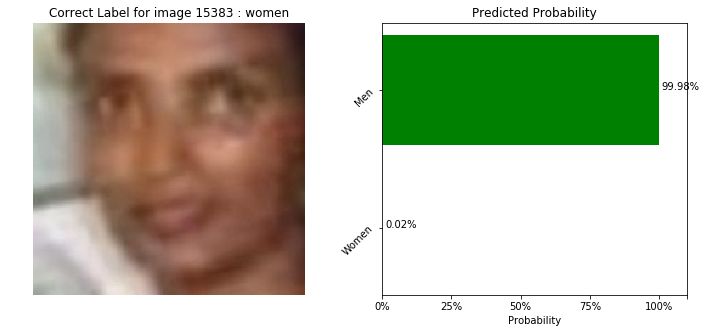

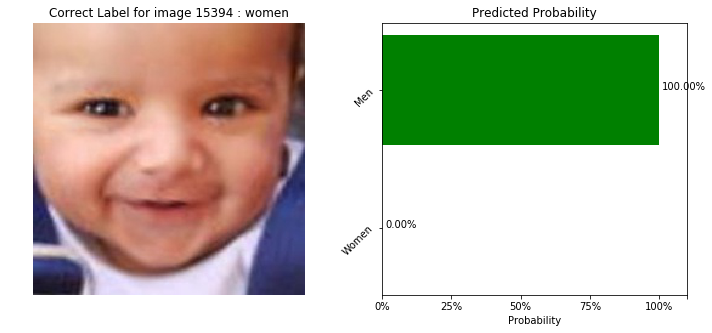

In [58]:
model_R50.plot_evaluate_res(img_type='M',randomize=True,n_images=8)

## Display Heat Maps Based on Image Classification Result Types

Randomly display heat maps have all been for correctly classified images. You can control the type of heat map images displayed when generating heat maps by providing values for the img_type parameter. The img_type parameter can contain three values: C to display only correct classifications, M to display only misclassified images, or the default value, A, which displays results for both correctly classified and misclassified images.


Running prediction ...
... finished running prediction
NOTE: The number of images in the table is too large, only 8 randomly selected images are used in analysis.
NOTE: Table SAMPLE_TBL_J8OTSX contains compressed images.


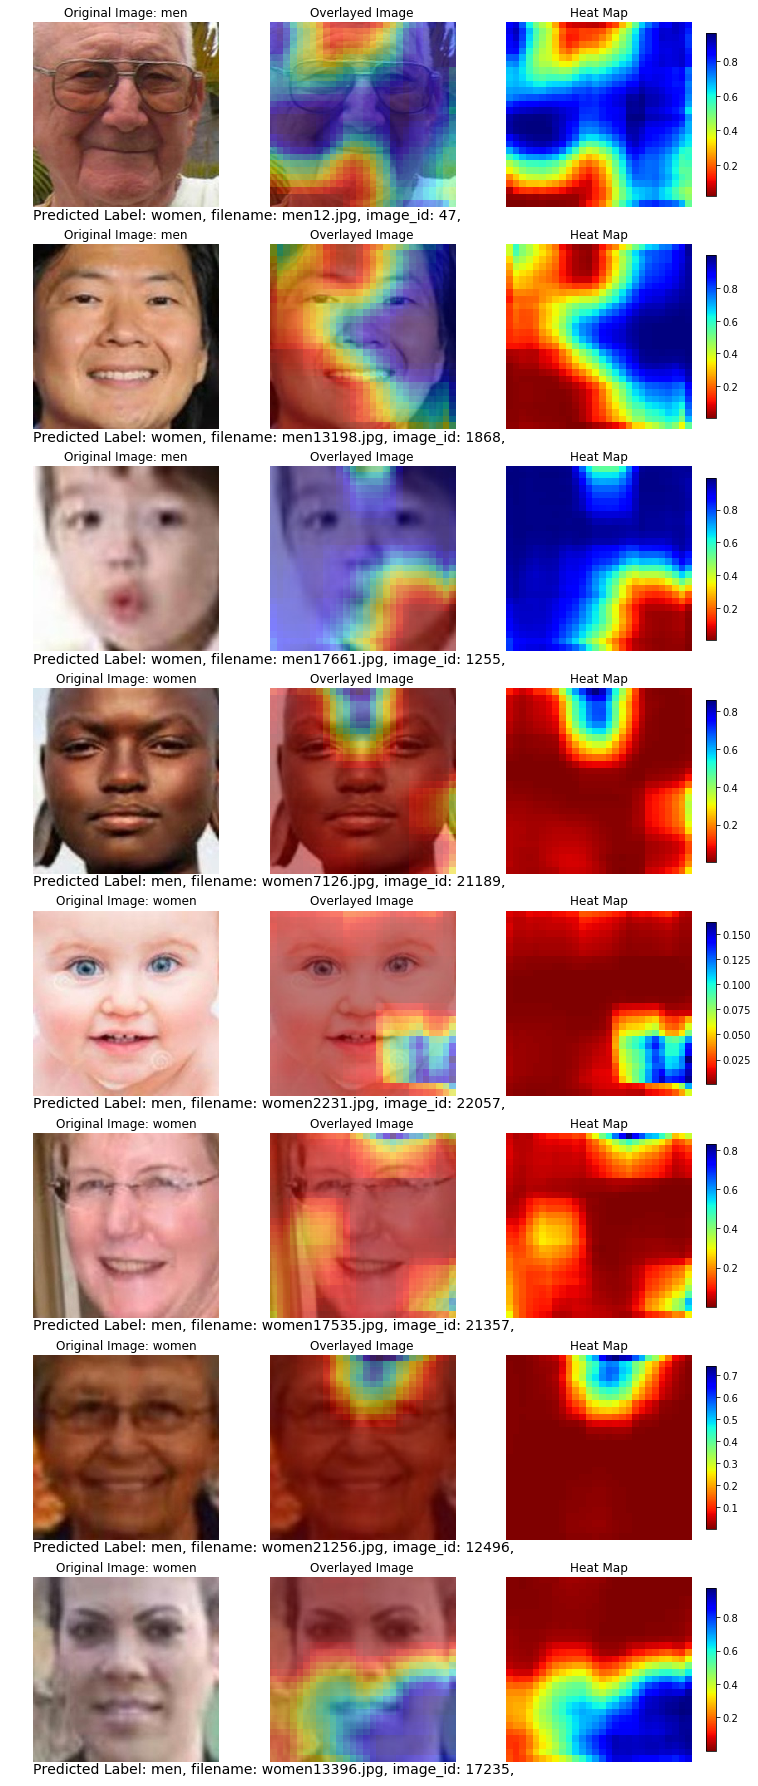

NOTE: Cloud Analytic Services dropped table SAMPLE_TBL_j8OTsX from caslib Happy.


In [63]:
misclass = model_R50.heat_map_analysis(data=te_img, mask_width=56, mask_height=56, step_size=8, img_type='M', max_display=8)

## Save Model as ASTORE for Deployment

The following code saves the model in ASTORE format which can then be used by SAS ESP to score live streaming event. 

In [61]:
model_R50.deploy(path=modelPath, output_format='astore')

NOTE: Model astore file saved successfully.


In [62]:
# Save Model Weights
s.save(model_R50.model_weights,
          name='model_R50_gender_weights_v1.sashdat',
          saveAttrs=True,
          replace=True);

NOTE: Cloud Analytic Services saved the file model_R50_gender_weights_v1.sashdat with attributes in caslib Happy.


In [64]:
s.endsession()

+ Elapsed: 0.000259s, user: 0.000222s, sys: 1.9e-05s, mem: 0.195mb